# Deep Survival Machines

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [53]:
import polars as pl
import numpy as np
import pandas as pd
import torch
import torchtuples as tt
import matplotlib.pyplot as plt
import seaborn as sns
from auton_survival.models.dsm import DeepSurvivalMachines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sklearn.metrics import log_loss
from sksurv.util import Surv
from pycox.evaluation import EvalSurv
from torchtuples.callbacks import Callback
from scipy.special import logit
import time
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'numpy',
    'torch',
    'torchtuples',
    'auton_survival',
    'pycox',
    'sksurv',
    'sklearn',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

df = pl.read_csv("data/prepared_data.csv")
df = df.with_columns(pl.col("earnings_quantile").cast(pl.Float64))
df = df.with_columns(pl.col("HRSLEEP").cast(pl.Int64))

dfp = df.to_pandas()
dfp_nn = dfp.dropna()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 1.5.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
numpy version: 1.26.4
torch version: 1.13.1
torchtuples version: 0.2.2
auton_survival version: built-in or no __version__
pycox version: 0.3.0
sksurv version: 0.21.0
sklearn version: 1.2.2
scipy version: 1.13.1


In [37]:
dfp_nn = dfp_nn.replace({"time": {0: 0.01}})
X = dfp_nn.drop(columns=["time", "event"])
T = dfp_nn["time"].to_numpy().astype('float32')
E = dfp_nn["event"].to_numpy().astype('bool')

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.to_numpy().astype('float32'))

y = Surv.from_arrays(event=E.astype(bool), time=T)

X_train, X_test, T_train, T_test, E_train, E_test, y_train, y_test = train_test_split(X_scaled, T, E, y, test_size=0.2, random_state=0)

np.random.seed(0)
torch.manual_seed(0)

model =  DeepSurvivalMachines (
    k = 10, # number of mixture components
    layers =[64, 32],
    distribution = "Weibull",
    random_seed = 0
)

start_time = time.time()
log = model.fit(X_train, T_train, E_train, iters=100, learning_rate = 2e-3)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

 22%|█████████▏                                | 22/100 [03:19<11:47,  9.07s/it]

Fitting time: 289.33 seconds


In [38]:
pred_surv = model.predict_survival(X_test.astype(float), 0)
for t in np.arange(11):
    pred_surv = np.hstack((pred_surv, model.predict_survival(X_test.astype(float), t)))

# C-index
c_index = concordance_index_censored(
    y_test["event"], y_test["time"], 1 - pred_surv[:,-1]
)[0]
print(f"C-index: {c_index:.4f}")

# IBS
time_grid = np.arange(1,10)
ibs = integrated_brier_score(y_test, y_test, pred_surv[:,1:10], time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

# Log loss
in_interval = ((y_test["event"] == True) & (y_test["time"] >= 2) & (y_test["time"] < 3)).astype(int)
p_interval =  pred_surv[:, 2] -  pred_surv[:, 3]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

C-index: 0.8705
Integrated Brier Score: 0.0423
Log loss for interval [2, 3): 0.0509


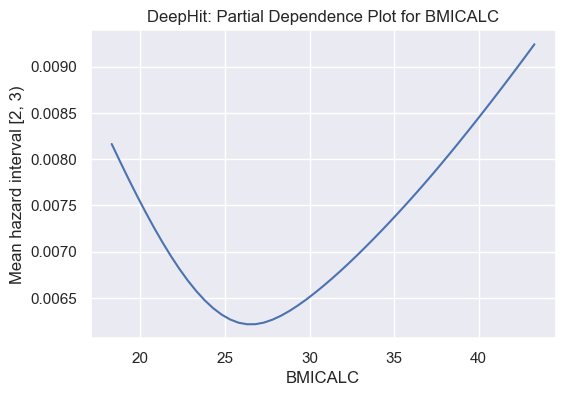

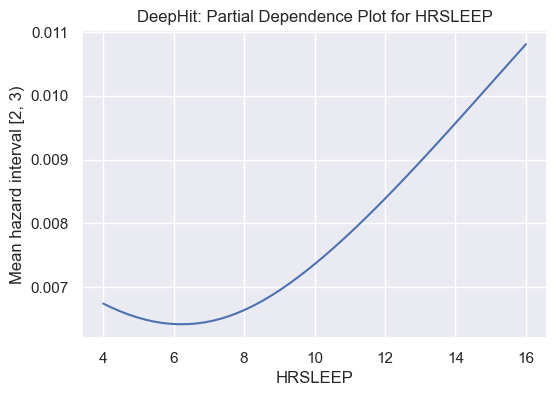

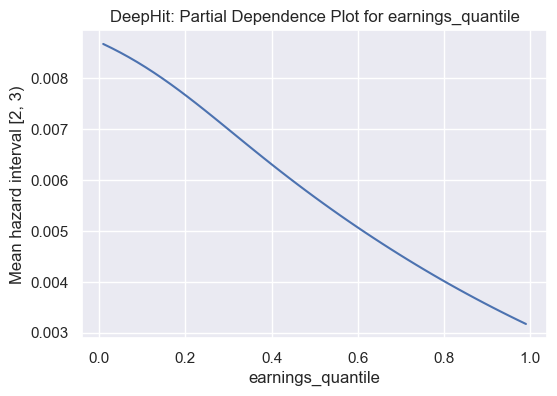

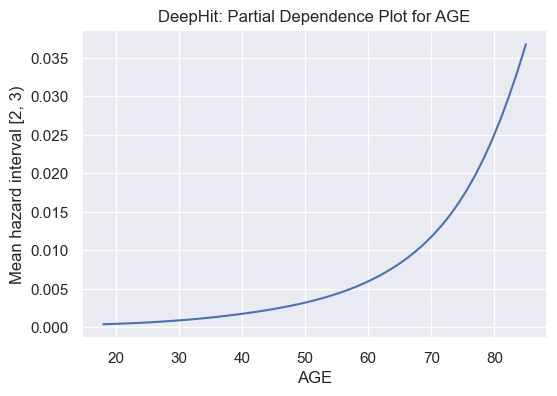

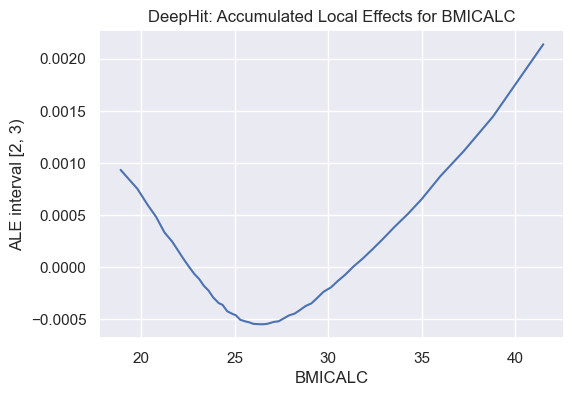

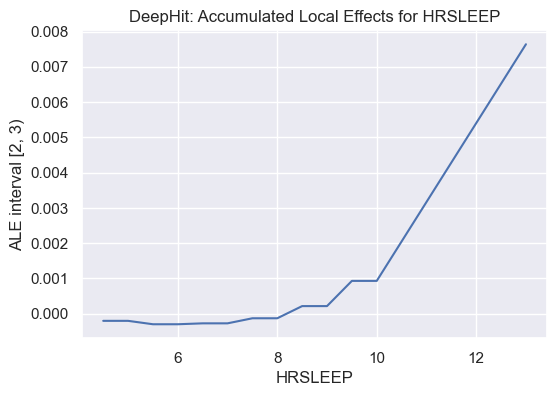

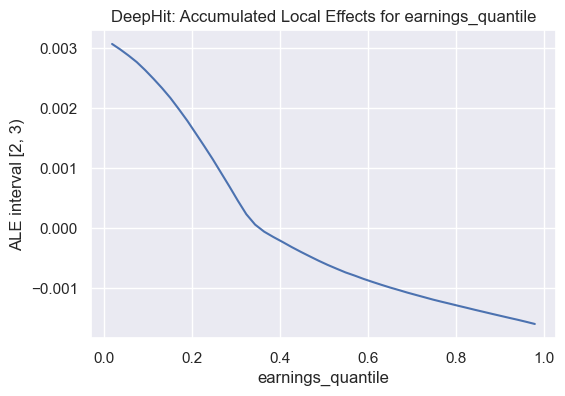

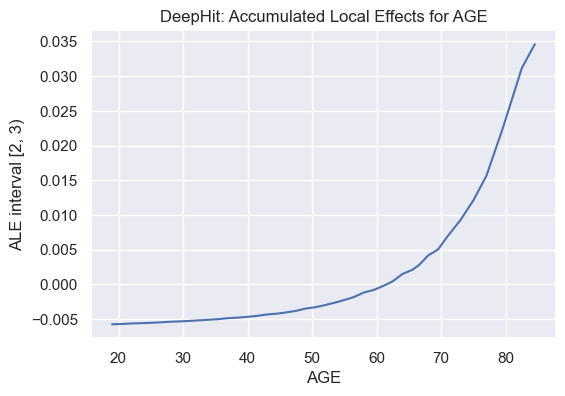

In [39]:
def plot_pdp(model, X_raw, X_scaled, variable, t1, t2):
    x_vals = np.linspace(X_raw[variable].quantile(0.01), X_raw[variable].quantile(0.99), 51)
    x_vals_scaled = np.linspace(np.quantile(X_scaled[:, X_raw.columns == variable], 0.01), np.quantile(X_scaled[:, X_raw.columns == variable], 0.99), 51)
    idx = X_raw.columns.get_loc(variable)
    y_vals = []

    for val in x_vals_scaled:
        X_copy = X_scaled.copy()
        X_copy[:, idx] = val
        y_vals.append((model.predict_survival(X_copy.astype(float), t1) - model.predict_survival(X_copy.astype(float), t2)).mean())

    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel(variable)
    plt.ylabel(f"Mean hazard interval [{t1}, {t2})")
    plt.title(f"DeepHit: Partial Dependence Plot for {variable}")
    plt.show()

def plot_ale(model, X_raw, X_scaled, variable, t1, t2):
    df = pd.DataFrame(data = X_scaled, columns = X_raw.columns)
    df_sorted = df.sort_values(by=variable)
    quantiles = np.linspace(0.01, 0.99, 51)
    bin_edges = df[variable].quantile(quantiles).values
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_edges_raw = X_raw[variable].quantile(quantiles).values
    bin_centers_raw = 0.5 * (bin_edges_raw[:-1] + bin_edges_raw[1:])
    
    ale_values = []
    for i in range(len(bin_edges) - 1):
        lower, upper = bin_edges[i], bin_edges[i+1]
        mask = (df[variable] >= lower) & (df[variable] < upper)
        df_bin = df[mask]
        
        if df_bin.empty:
            ale_values.append(0.0)
            continue
        
        df_low = df_bin.copy()
        df_high = df_bin.copy()
        df_low[variable] = lower
        df_high[variable] = upper

        pred_diff = (model.predict_survival(df_high.to_numpy().astype(float), t1) - model.predict_survival(df_high.to_numpy().astype(float), t2)) - (model.predict_survival(df_low.to_numpy().astype(float), t1) - model.predict_survival(df_low.to_numpy().astype(float), t2))
        ale_values.append(np.mean(pred_diff))
    
    # Accumulate local effects
    ale_accumulated = np.cumsum(ale_values)
    ale_centered = ale_accumulated - np.mean(ale_accumulated)  # Centering
    
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers_raw, ale_centered)
    plt.xlabel(variable)
    plt.ylabel(f"ALE interval [{t1}, {t2})")
    plt.title(f"DeepHit: Accumulated Local Effects for {variable}")
    plt.show()

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_pdp(model, X, X_scaled, var, 2, 3)

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_ale(model, X, X_scaled, var, 2, 3)

In [41]:
D2 = pd.read_csv("data/D2.csv")
D2["T"] = np.floor(D2["T"])
D2 = D2.replace({"T": {0: 0.01}})

X_D2 = D2.drop(columns=["T", "event", "mu", "BMI_scaled", "SBP_scaled", "SD_SBP_scaled", "TCL_HDL_RATIO_scaled"])
T_D2 = D2["T"].to_numpy().astype('float32')
E_D2 = D2["event"].to_numpy().astype('bool')
mu_D2 = D2["mu"].to_numpy().astype('float32')

scaler = MinMaxScaler()
X_D2_scaled = scaler.fit_transform(X_D2.to_numpy().astype('float32'))

y_D2 = Surv.from_arrays(event=E_D2.astype(bool), time=T_D2)

X_D2_train, X_D2_test, T_D2_train, T_D2_test, E_D2_train, E_D2_test, y_D2_train, y_D2_test, _, mu_D2_test = train_test_split(X_D2_scaled, T_D2, E_D2, y_D2, mu_D2, test_size=0.2, random_state=0)

np.random.seed(0)
torch.manual_seed(0)

model_D2 =  DeepSurvivalMachines (
    k = 10, # number of mixture components
    layers =[64, 32],
    distribution = "Weibull",
    random_seed = 0
)

start_time = time.time()
log = model_D2.fit(X_D2_train, T_D2_train, E_D2_train, iters=100, learning_rate = 2e-3)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

 22%|████████▊                               | 22/100 [18:07<1:04:17, 49.45s/it]

Fitting time: 1859.54 seconds


In [42]:
pred_surv = model_D2.predict_survival(X_D2_test.astype(float), 0)
for t in np.arange(11):
    pred_surv = np.hstack((pred_surv, model_D2.predict_survival(X_D2_test.astype(float), t)))

# C-index
c_index = concordance_index_censored(
    y_D2_test["event"], y_D2_test["time"], 1 - pred_surv[:,-1]
)[0]
print(f"C-index: {c_index:.4f}")

# IBS
time_grid = np.arange(1,10)
ibs = integrated_brier_score(y_D2_test, y_D2_test, pred_surv[:,1:10], time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

# Log loss
in_interval = (y_D2_test["event"] == True).astype(int)
p_interval =  1 -  pred_surv[:, -1]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.9065
Integrated Brier Score: 0.0369
Log loss for interval [0, 10): 0.1855


In [50]:
pred = np.maximum(1e-3, 1 - pred_surv[:,-1])
mse = np.mean(np.square(np.log(mu_D2_test) - np.log(pred)))
dev = -2*np.sum(E_D2_test*logit(pred) + np.log(1-pred))
kld = -np.sum(np.log(pred[E_D2_test==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    0.1588
Logistic deviance:           102118
Kullback-Leibler divergence: 33682


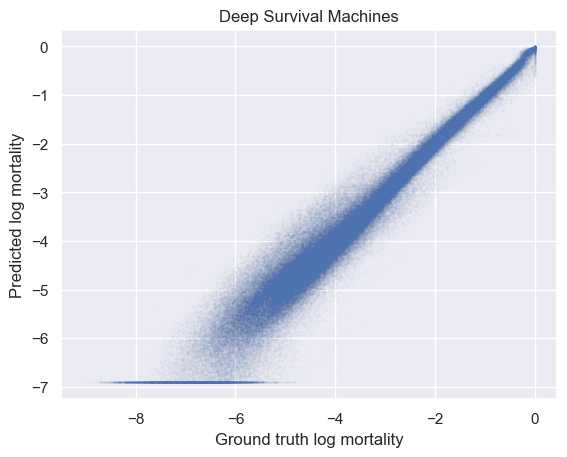

In [51]:
plt.plot(np.log(mu_D2_test), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("Deep Survival Machines")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

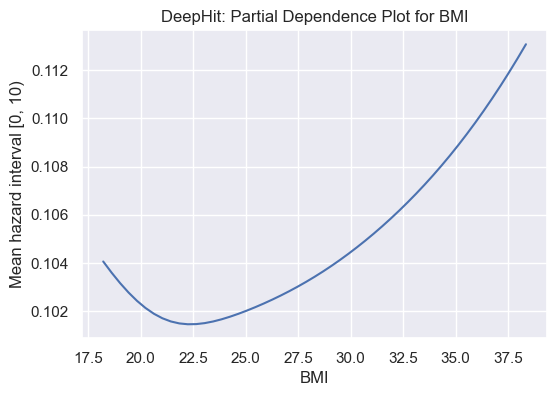

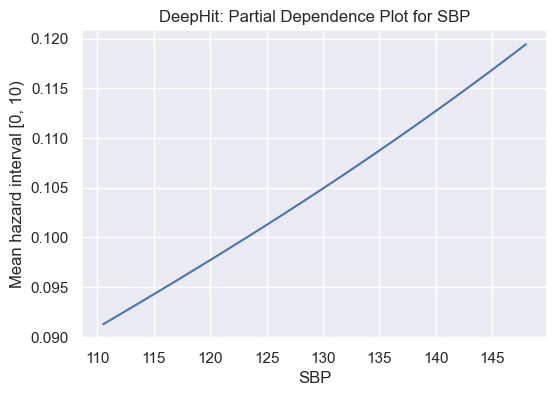

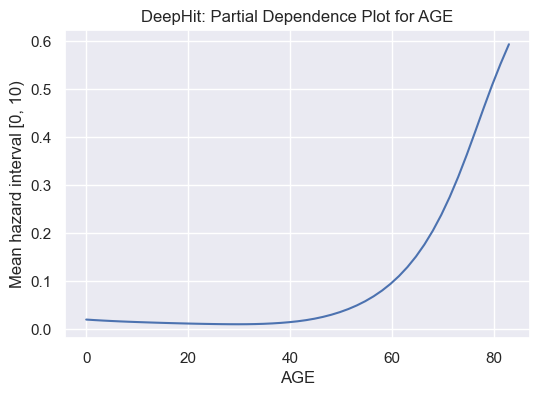

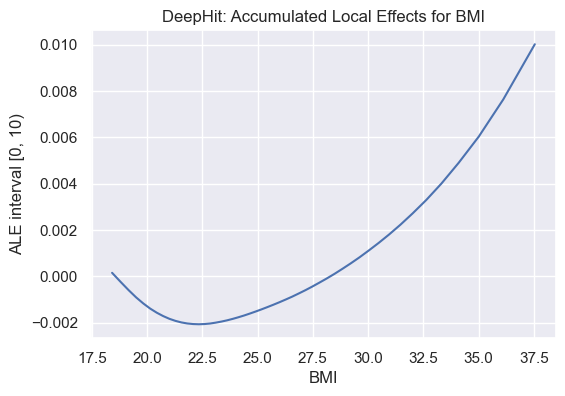

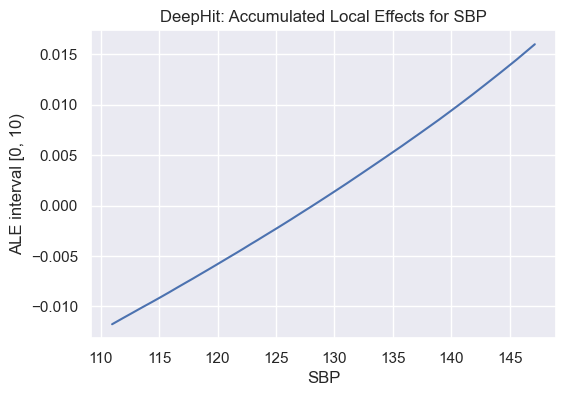

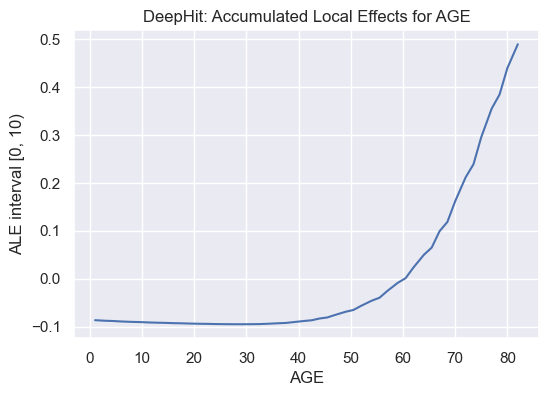

In [52]:
for var in ["BMI", "SBP", "AGE"]:
    plot_pdp(model_D2, X_D2, X_D2_scaled, var, 0, 10)

for var in ["BMI", "SBP", "AGE"]:
    plot_ale(model_D2, X_D2, X_D2_scaled, var, 0, 10)